### Final Propensity matching results

In [1]:
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [3]:
%reload_ext Cython

In [4]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [5]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR, make_MYR_to_date
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )
import data_process
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')
from utils import statistics_first_month, p_val, stat_matrices 
from path import col_seq_can_all, col_seq_can 
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type

In [6]:
# #setup cython
# #for cython build if needed -> cd to /modules folder and then run
# %cd ..
# !python3 setup.py build_ext --inplace
# %cd ./causal_data_creation/canary_application/

In [7]:
%config Completer.use_jedi = False

### Load pre matching data

In [8]:
pp_str = 'Pre_Matching_DATA/'
Path("./"+pp_str).mkdir(exist_ok=True)

In [9]:
# %%time
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/treated2.p ./Pre_Matching_DATA/treated2.p; 
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/controls.p ./Pre_Matching_DATA/controls.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/pmpm.p ./Pre_Matching_DATA/pmpm.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/tempHybridSelectionMoreData/random.p ./Pre_Matching_DATA/random.p;

In [10]:
treated = pd.read_pickle(pp_str+'treated2Past2.p')
controls = pd.read_pickle(pp_str+'controlsPast.p')
controls2  = controls[controls['HasPast'] == 1].reset_index(drop = True)
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle(pp_str+'random.p')

In [11]:
pmpm.MBR_GNDR.replace({"F":0,"M":1}, inplace=True)

In [12]:
treated.shape, treated.MYR.min(), treated.MYR.max()

((22364, 92), 201710, 202107)

In [13]:
controls.shape, controls.MYR.min(), controls.MYR.max()

((9582196, 92), 201701, 202107)

In [14]:
pmpm.shape, pmpm.MYR.min(), pmpm.MYR.max()

((9650961, 91), 201701, 202107)

# Check continuity and take average of 1 year history

### Treated

In [15]:
# def get_treated_agg(treated, pmpm):
    
#     #get one year before dates
#     treated_history = pmpm[pmpm.PERS_ID.isin(treated.PERS_ID)]
#     treated.drop(['MEDICAID_LOB'], axis=1, inplace=True)
#     treated['MYR_12'] = treated.MYR.apply(data_process.get_one_year_before, offset_month=12)
    
#     treated_aggregate = pd.DataFrame(columns=col_seq_can_all)
#     for i, (index, row) in tqdm(enumerate(treated.iterrows())):
#         pid = row.PERS_ID
#         myr = row.MYR
#         old_myr = row.MYR_12
#         history = treated_history.query("PERS_ID==@pid & MYR>=@old_myr & MYR<=@myr")
#         agg_data = history[col_seq_can_all].mean()
#         agg_data.PERS_ID = str(int(row.PERS_ID))
#         agg_data.MYR     = int(row.MYR)
#         treated_aggregate = pd.concat([treated_aggregate, pd.DataFrame(agg_data).T], axis=0)
            
#     treated_aggregate.PERS_ID = treated_aggregate.astype(int).astype(str)
#     treated_aggregate.MYR = treated_aggregate.MYR.astype(int)
    
#     treated_aggregate = treated_aggregate.reset_index(drop=True)
    
#     return treated_aggregate
    

In [16]:
# %%time
# treated_aggregate = get_treated_agg(treated.copy(), pmpm.copy())
# treated_aggregate.to_pickle("./Final/Data/Common/treated_aggregated_filtered_final_g.p")

In [17]:
sorted_months = treated.MYR.sort_values().unique()

In [18]:
sorted_months

array([201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805,
       201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901,
       201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909,
       201910, 201911, 201912, 202001, 202002, 202003, 202004, 202005,
       202006, 202007, 202008, 202009, 202010, 202011, 202012, 202101,
       202102, 202103, 202104, 202105, 202106, 202107])

In [19]:
treated_aggregate = pd.read_pickle("./Final/Data/Common/treated_aggregated_filtered_final_g.p") #goes into matching as tr_agg

In [20]:
#controls_aggregate = data_process.get_average_final_record(controls2.copy(), sorted_months, pmpm[col_seq_can_all].copy())
#controls_aggregate.to_pickle("./Final/Data/Common/controls_aggregated_filtered_final_g.p")

In [21]:
controls_aggregate = pd.read_pickle("./Final/Data/Common/controls_aggregated_filtered_final_g.p")

In [22]:
controls_aggregate.shape, controls2.shape

In [23]:
treated_original = treated[treated.set_index(['PERS_ID','MYR']).index.isin(treated_aggregate.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)
controls_original = controls2[controls2.set_index(['PERS_ID','MYR']).index.isin(controls_aggregate.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [24]:
del treated, controls, controls2

In [25]:
# !aws s3 cp ./Final/Data/PCA/treated_aggregated_filtered_final.p s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/Agg_Data_Common/treated_agg.p --acl bucket-owner-full-control
# !aws s3 cp ./Final/Data/PCA/controls_aggregated_filtered_final.p s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/Agg_Data_Common/controls_agg.p --acl bucket-owner-full-control

# Load Model and Pick Columns for Matching

In [26]:
treated_aggregate[['ALLOW_AMT', 'ALLOW_IP', 'ALLOW_ER']] = treated_aggregate[['ALLOW_AMT', 'ALLOW_IP', 'ALLOW_ER']].apply(data_process.log_)
controls_aggregate[['ALLOW_AMT', 'ALLOW_IP', 'ALLOW_ER']] = controls_aggregate[['ALLOW_AMT', 'ALLOW_IP', 'ALLOW_ER']].apply(data_process.log_)

In [27]:
treated_aggregate.head()

PERS_ID     MYR  AGE_AT_MIDMONTH  LOB  MBR_GNDR  ALLOW_AMT   ALLOW_ER   ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0  2602482  201908        80.769231  1.0       0.0   5.630384 -16.118096 -16.118096      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0              1.0   3.307692                    0.0          0.0              0.0     0.846154                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0           0.538462         0.923077             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1  2602482  201909        80.846154  1.0       0.0   5.902843 -16.118096 -16.118096      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0              1.0   3.153846                    0.0          0.0              0.0     0.769231                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0           0.461538         0.923077             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
2  2602482  201910        80.923077  1.0       0.0   5.930203 -16.118096 -16.118096      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0              1.0   3.000000                    0.0          0.0              0.0     0.692308                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0           0.384615         0.923077             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
3  2602482  201911        81.076923

In [28]:
model = models.load_model(pp_str+"TF_Latent_Model_m6_Canary_stacked_AE_logfixed", compile=False)

In [29]:
latent_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

In [30]:
onset = "CC_DIABETES"
cols_to_keep = ["PERS_ID", "MYR", 'AGE_AT_MIDMONTH', 'MBR_GNDR',  onset]
extra_cols = ['IP_BIN6', 'ER_BIN6','LOB']

In [31]:
treated_latent = data_process.transform_features_with_NN(model, treated_aggregate[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
treated_latent1 = treated_original[cols_to_keep+extra_cols]
treated_latent = pd.concat([treated_latent1, treated_latent.loc[:,'x1':]], axis=1)

In [32]:
controls_latent = data_process.transform_features_with_NN(model, controls_aggregate[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
controls_latent1 = controls_original[cols_to_keep+extra_cols]
controls_latent = pd.concat([controls_latent1, controls_latent.loc[:,'x1':]], axis=1)

In [33]:
del treated_latent1, controls_latent1

In [34]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

all_columns1 = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB',
                                                         'IP_BIN', 'ER_BIN', 'ACUTE', 'IP_C', 'ER_C', 'ACUTE_C','IP_BIN2', 'ER_BIN2']))

all_columns2 = list(set(all_columns1)-set(['IP_BIN6', 'ER_BIN6', 'LOB']))

In [35]:
controls_latent.shape, controls_original.shape

# Matching

In [36]:
%%time
match_on = latent_cols
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict}
matched0, matched_data0 = matched_population(treated_latent.copy(), 
                                           controls_latent.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:263545 before they were:293527


0it [00:00, ?it/s]

IP_BIN6 [0, 1, 2]
ER_BIN6 [0, 1, 2]
LOB None


1367it [21:15,  1.07it/s]

There were no matches for 0 out of 1367 patients
CPU times: user 31min 21s, sys: 21min 42s, total: 53min 4s
Wall time: 21min 18s


In [42]:
# matched0.to_pickle("matched0.p")
# matched_data0.to_pickle("matched_data0.p")

In [37]:
controls = pd.read_pickle(pp_str+'controlsPast.p')

In [46]:
controls_all =  pd.DataFrame()
matched_data1 = pd.DataFrame()
controls22 = controls.copy()
controls22 = controls22.set_index('PERS_ID', drop = False)

In [47]:
%%time
counter = 0

for (key, month), val in tqdm(matched0.items()):
    val['RD'] = val.MYR
    first = controls22.loc[val['PERS_ID']].reset_index(drop = True)
    
    new_dat = pd.merge(first, val[['PERS_ID','RD']],  on = 'PERS_ID',)
    new_dat['PERS_ID2'] = new_dat.PERS_ID
    new_dat['PERS_ID'] = new_dat['PERS_ID']+str(counter)    
    filt = new_dat.MYR >= new_dat.RD
    new_dat2 = new_dat[filt].reset_index(drop = True)
    
    #control_groups[group] = new_dat2
    matched_data1 = pd.concat((matched_data1, new_dat2), ignore_index = True)
    controls_all = pd.concat((controls_all, new_dat), ignore_index = True)
    counter += 1

100%|██████████| 1367/1367 [09:13<00:00,  2.47it/s]

CPU times: user 7min 43s, sys: 1min 30s, total: 9min 14s
Wall time: 9min 13s


In [48]:
matched_data0

PERS_ID     MYR  AGE_AT_MIDMONTH  MBR_GNDR  CC_DIABETES  IP_BIN6  ER_BIN6  LOB        x1        x2        x3         x4        x5        x6        x7        x8        x9       x10       x11       x12       x13       x14        x15        x16
0      2603457  201908               81         0          0.0      0.0      0.0    1 -0.001860  7.083612  0.006458  33.392273  0.349191 -0.315959  0.099748 -0.379833 -0.322218 -0.186055  0.481640 -0.096198 -0.078081 -0.235188  33.754295  21.934269
1      2603457  201909               81         0          0.0      0.0      0.0    1 -0.005693  8.551653  0.000677  39.777000  0.405900 -0.367009  0.120797 -0.449827 -0.379635 -0.300655  0.574326 -0.111215 -0.014878 -0.282788  40.197506  26.166969
2      2603457  201910               81         0          0.0      0.0      0.0    1 -0.001586  7.020239  0.006756  33.118565  0.346825 -0.313907  0.098758 -0.376745 -0.319761 -0.181280  0.477700 -0.095559 -0.080813 -0.233039  33.478039  21.752096
3      2603457  201911               81         0          0.0      0.0      0.0    1  0.002202  5.899163  0.010791  28.246231  0.305396 -0.277173  0.080188 -0.324165 -0.276563 -0.096192  0.407727 -0.085420 -0.129545 -0.197382  28.564779  18.525133
4      2603457  201912               81         0          0.0      0.0      0.0    1  0.001825  6.098155  0.010079  29.114582  0.313126 -0.284252  0.083061 -0.333498 -0.284410 -0.111827  0.420354 -0.087419 -0.120890 -0.203643  29.440756  19.099638
...        ...     ...              ...       ...          ...      ...      ...  ...       ...       ...       ...        ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...        ...        ...
80755  3993662  202106               30         0          0.0      0.0      0.0    1  0.019550 -0.517898  0.034356   0.376262  0.054697 -0.050716 -0.008650 -0.014972 -0.023071  0.409576 -0.000362 -0.013883 -0.418916  0.009840   0.454863   0.072538
80756  3993662  202107               30         0          0.0      0.0      0.0    1  0.019537 -0.523479  0.034402   0.352006  0.054440 -0.050440 -0.008670 -0.014634 -0.022782  0.410149 -0.000798 -0.013729 -0.419348  0.010005   0.430819   0.056454
80757  4258527  202012               32         0          0.0      0.0      0.0    1  0.019499 -0.542482  0.034579   0.269461  0.053531 -0.049474 -0.008688 -0.013478 -0.021831  0.412024 -0.002279 -0.013213 -0.420752  0.010594   0.349027   0.001608
80758  4258527  202101               32         0          0.0      0.0      0.0    1  0.019500 -0.539775  0.034550   0.281151  0.053664 -0.049607 -0.008695 -0.013652 -0.021973  0.411729 -0.002063 -0.013297 -0.420534  0.010520   0.360629   0.009347
80759  4258527  202102               32         0          0.0      0.0      0.0    1  0.019508 -0.535275  0.034508   0.300759  0.053880 -0.049839 -0.008691 -0.013929 -0.022205  0.411230 -0.001709 -0.013418 -0.420200  0.010380   0.380157   0.022353

[80760 rows x 24 columns]

In [49]:
matched_data1

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  \
0          26042250  201908         0               81         30     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
1          26042250  201909         0               81        199     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
2          26042250  201910         0               81        186     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
3          26042250  201911     

In [50]:
def get_data(data_struct):
    keys = list(data_struct)
    dat1 = pd.DataFrame()
    for key in keys:
        dat1 = pd.concat([dat1, data_struct[key]], ignore_index=True)
    return dat1

In [51]:
matched_controls_5N = get_data(matched0)

### Result Folder Base

In [52]:
data_base = "./Final/Data/AE_g/"
result_base = "./Final/results/AE_g/"
Path(data_base).mkdir(exist_ok=True)
Path(result_base).mkdir(exist_ok=True)

In [53]:
matched_controls_5N.to_pickle(data_base+"matched0.p")

In [54]:
controls_all.to_pickle(data_base+'controls_all.p')

In [55]:
matched_data0.to_pickle(data_base+"matched_controls_latent_from_algo.p")

In [56]:
matched_data1.to_pickle(data_base+"matched_controls_latent_after_process.p")

### Calculate matched controls agg and matched controls original 

In [57]:
# matched_controls_original = controls[controls.set_index(['PERS_ID','MYR']).index.isin(matched_data1.set_index(['PERS_ID2','MYR']).index)].reset_index(drop=True)

In [58]:
matched_controls_original = matched_data1

In [59]:
matched_controls_original.to_pickle(data_base+"matched_controls_original.p")

In [60]:
matched_controls_aggregate = controls_aggregate[controls_aggregate.set_index(['PERS_ID','MYR']).index.isin(matched_data0.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [61]:
matched_controls_aggregate.to_pickle(data_base+"matched_controls_aggregate.p")

### List containing all numerical columns

In [62]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

# Statistics First Month Original

In [63]:
# del controls, controls2

In [64]:
treated = pd.read_pickle(pp_str+'treated2Past2.p')

In [65]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_controls_original, all_columns, return_array = True)

pmpm_desc = statistics_first_month(pmpm, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)


CPU times: user 2min 29s, sys: 8.08 s, total: 2min 37s
Wall time: 2min 37s


In [66]:
conds_first

Treated Matched Controls    Test-TC               General Population      Random
                       mean             mean     t-stat          pval               mean        mean
AGE_AT_MIDMONTH   50.738113        50.792588  -0.147186  8.829886e-01          44.310976   47.606399
ALLOW_AMT        712.070227       827.017138  -0.951324  3.414678e-01        1065.926022  648.802692
MBR_GNDR           0.212143         0.211953   0.015756  9.874295e-01           0.442749    0.431056
CC_TOBACCO         0.061448         0.089937  -3.446174  5.714384e-04           0.074202    0.098400
CC_PRESSURE        0.001463         0.003369  -1.166219  2.435599e-01           0.007390    0.006602
CC_OBESITY         0.498903         0.293247  14.987921  4.050425e-50           0.108841    0.228035
CC_HYPERTENSION    0.342356         0.247254   7.311817  2.883958e-13           0.207717    0.249365
CC_HYPOTHYROID     0.100951         0.081295   2.384606  1.712003e-02           0.047300    0.063484
CC_DX_CNT          2.912217         2.384356   8.040888  1.016541e-15           1.824419    2.343702
ACUTE2             0.039503         0.033250   1.096557  2.728672e-01           0.063258    0.051549
ACUTE6             0.115582         0.109565   0.517375  6.049086e-01           0.063258    0.153377
IP_BIN6            0.029993         0.026512   0.637622  5.237373e-01           0.020587    0.046851
ER_BIN6            0.091441         0.086715   0.464465  6.423267e-01           0.047286    0.116176
LOB                0.954645         0.955764  -0.183217  8.546324e-01           0.755775    0.787836

In [67]:
conds_first.to_csv(result_base+"stats_matching/conds_original_first.csv", index=True, header=True)
full_first.to_csv(result_base+"stats_matching/full_original_first.csv", index=True, header=True)
conds_firstAllCols.to_csv(result_base+"stats_matching/conds_original_first_allcols.csv", index=True, header=True)
full_firstAllCols.to_csv(result_base+"stats_matching/full_original_first_allcols.csv", index=True, header=True)

# Latent First Month

In [68]:
%%time
tr_desc0_l, treated_first_month_l = statistics_first_month(treated_latent, latent_cols, return_array = True)
con_desc0_l, controls_first_month_l = statistics_first_month(matched_data0, latent_cols, return_array = True)

conds_lat, full_lat = stat_matrices(tr_desc0_l, con_desc0_l, tr_desc0_l, tr_desc0_l, columns = latent_cols)


CPU times: user 2.13 s, sys: 0 ns, total: 2.13 s
Wall time: 2.13 s


In [69]:
conds_lat

Treated Matched Controls   Test-TC           General Population     Random
          mean             mean    t-stat      pval               mean       mean
x1    0.013518         0.013430  0.458252  0.646786           0.013518   0.013518
x2    1.780845         1.831368 -0.898367  0.369020           1.780845   1.780845
x3    0.026278         0.026017  1.283810  0.199250           0.026278   0.026278
x4   10.365922        10.590959 -0.925669  0.354650          10.365922  10.365922
x5    0.146110         0.148076 -0.905325  0.365324           0.146110   0.146110
x6   -0.133550        -0.135257  0.868530  0.385134          -0.133550  -0.133550
x7    0.023570         0.024832 -1.608422  0.107787           0.023570   0.023570
x8   -0.123341        -0.124772  0.472802  0.636369          -0.123341  -0.123341
x9   -0.112330        -0.113594  0.518831  0.603895          -0.112330  -0.112330
x10   0.232375         0.230058  0.469277  0.638886           0.232375   0.232375
x11   0.144109         0.146501 -0.630128  0.528631           0.144109   0.144109
x12  -0.038525        -0.038116 -0.369231  0.711966          -0.038525  -0.038525
x13  -0.315022        -0.314244 -0.252420  0.800723          -0.315022  -0.315022
x14  -0.064786        -0.066607  1.022264  0.306691          -0.064786  -0.064786
x15  10.523558        10.750694 -0.926308  0.354317          10.523558  10.523558
x16   6.674597         6.823166 -0.922311  0.356397           6.674597   6.674597

In [70]:
conds_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_lat_first.csv", index=True, header=True)
full_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_lat_first.csv", index=True, header=True)

# Agg First Month

In [71]:
%%time
without_custom_cols = [cols for cols in all_columns if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]
selected_without_custom_cols = [cols for cols in columns_to_match if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]

tr_desc0_agg, treated_agg_first_month = statistics_first_month(treated_aggregate, without_custom_cols, return_array = True)
con_desc0_agg, controls_agg_first_month = statistics_first_month(matched_controls_aggregate, without_custom_cols, return_array = True)

conds_agg, full_agg = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllCols, full_aggAllCols = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)


CPU times: user 2.58 s, sys: 5.52 ms, total: 2.59 s
Wall time: 2.59 s


In [72]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].round(3)

Treated Matched Controls Test-TC       
                   mean             mean  t-stat   pval
AGE_AT_MIDMONTH  50.261           50.500  -0.624  0.533
ALLOW_AMT         5.772            5.428   4.859  0.000
MBR_GNDR          0.212            0.236  -1.881  0.060
CC_TOBACCO        0.055            0.091  -4.544  0.000
CC_PRESSURE       0.001            0.003  -1.096  0.273
CC_OBESITY        0.442            0.263  14.224  0.000
CC_HYPERTENSION   0.320            0.242   6.497  0.000
CC_HYPOTHYROID    0.090            0.079   1.412  0.158
CC_DX_CNT         2.649            2.279   5.848  0.000
LOB               0.954            0.944   1.457  0.145

In [73]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_first.csv", index=True, header=True)
full_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_first.csv", index=True, header=True)
conds_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_first_allcols.csv", index=True, header=True)
full_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_first_allcols.csv", index=True, header=True)

# Stat all Original

In [74]:
%%time
tr_desc0A = treated[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_controls_original[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

pmpm_descA = pmpm[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)


CPU times: user 28.6 s, sys: 11.8 s, total: 40.5 s
Wall time: 40.5 s


In [75]:
conds.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   51.079           51.494  -4.582  0.000             50.379   50.236
ALLOW_AMT        812.538          793.587   0.667  0.505            857.856  706.609
MBR_GNDR           0.196            0.199  -0.909  0.364              0.433    0.429
CC_TOBACCO         0.064            0.094 -14.143  0.000              0.102    0.100
CC_PRESSURE        0.003            0.004  -3.098  0.002              0.013    0.008
CC_OBESITY         0.533            0.336  55.670  0.000              0.255    0.286
CC_HYPERTENSION    0.332            0.257  22.796  0.000              0.329    0.300
CC_HYPOTHYROID     0.098            0.087   5.195  0.000              0.078    0.075
CC_DX_CNT          3.049            2.619  25.534  0.000              2.955    2.759
ACUTE2             0.032            0.034  -1.287  0.198              0.060    0.050
ACUTE6             0.101            0.103  -0.925  0.355              0.168    0.150
IP_BIN6            0.026            0.031  -3.461  0.001              0.055    0.049
ER_BIN6            0.079            0.077   0.717  0.474              0.122    0.111
LOB                0.955            0.954   1.020  0.308              0.802    0.803

In [76]:
conds.to_csv(result_base+"stats_matching/conds_original.csv", index=True, header=True)
full.to_csv(result_base+"stats_matching/full_original.csv", index=True, header=True)
conds_AllCols.to_csv(result_base+"stats_matching/conds_original_allcols.csv", index=True, header=True)
full_AllCols.to_csv(result_base+"stats_matching/full_original_allcols.csv", index=True, header=True)

# Latent Alltime

In [77]:
%%time
tr_desc0_latA = treated_latent[latent_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_latA['count'] = tr_desc0_latA['count'].astype(int)

con_desc0_latA = matched_data0[latent_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_latA['count'] = con_desc0_latA['count'].astype(int)

conds_latA, full_latA = stat_matrices(tr_desc0_latA, con_desc0_latA, tr_desc0_latA, tr_desc0_latA, columns = latent_cols)


CPU times: user 129 ms, sys: 587 µs, total: 130 ms
Wall time: 129 ms


In [78]:
conds_latA

Treated Matched Controls    Test-TC                General Population     Random
          mean             mean     t-stat           pval               mean       mean
x1    0.013309         0.014597 -17.782587   1.230058e-70           0.013309   0.013309
x2    1.822448         1.877423  -3.490683   4.819888e-04           1.822448   1.822448
x3    0.026218         0.024740  25.550362  1.526836e-143           0.026218   0.026218
x4   10.539924        10.865697  -4.822956   1.416474e-06          10.539924  10.539924
x5    0.147624         0.151284  -6.124447   9.132607e-10           0.147624   0.147624
x6   -0.134977        -0.137764   5.134483   2.834336e-07          -0.134977  -0.134977
x7    0.023594         0.031094 -31.253200  2.020987e-213           0.023594   0.023594
x8   -0.126536        -0.114498 -12.018093   3.004900e-33          -0.126536  -0.126536
x9   -0.114836        -0.106516 -10.557531   4.834182e-26          -0.114836  -0.114836
x10   0.227155         0.246346 -11.800581   4.065421e-32           0.227155   0.227155
x11   0.147729         0.139405   7.103132   1.227457e-12           0.147729   0.147729
x12  -0.040084        -0.027110 -26.251519  2.168062e-151          -0.040084  -0.040084
x13  -0.311368        -0.330898  17.473332   2.870332e-68          -0.311368  -0.311368
x14  -0.065871        -0.070819  10.223866   1.592703e-24          -0.065871  -0.065871
x15  10.698804        11.029761  -4.858302   1.185698e-06          10.698804  10.698804
x16   6.790465         6.998797  -4.649221   3.336030e-06           6.790465   6.790465

In [79]:
conds_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_lat_allcols.csv", index=True, header=True)
full_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_lat_allcols.csv", index=True, header=True)

# Agg alltime

In [80]:
%%time
tr_desc0_aggA = treated_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_aggA['count'] = tr_desc0_aggA['count'].astype(int)

con_desc0_aggA = matched_controls_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_aggA['count'] = con_desc0_aggA['count'].astype(int)

conds_aggA, full_aggA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllColsA, full_aggAllColsA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)



CPU times: user 574 ms, sys: 0 ns, total: 574 ms
Wall time: 573 ms


In [81]:
conds_aggA

Treated Matched Controls    Test-TC               General Population     Random
                      mean             mean     t-stat          pval               mean       mean
AGE_AT_MIDMONTH  50.584865        51.309157  -7.687113  1.518140e-14          50.260886  50.260886
ALLOW_AMT         5.740478         5.576668  10.516067  7.508234e-26           5.772460   5.772460
MBR_GNDR          0.196074         0.221105  -8.057141  7.892612e-16           0.212143   0.212143
CC_TOBACCO        0.062775         0.094722 -15.697061  1.837081e-55           0.054730   0.054730
CC_PRESSURE       0.001861         0.003881  -4.934925  8.030635e-07           0.001407   0.001407
CC_OBESITY        0.512188         0.325943  55.482771  0.000000e+00           0.442005   0.442005
CC_HYPERTENSION   0.327053         0.266369  19.501459  1.516508e-84           0.320176   0.320176
CC_HYPOTHYROID    0.093022         0.089031   2.015697  4.383428e-02           0.089568   0.089568
CC_DX_CNT         2.891615         2.586842  18.769242  1.822993e-78           2.648890   2.648890
LOB               0.956211         0.950147   3.783799  1.545396e-04           0.954162   0.954162

In [82]:
conds_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg.csv", index=True, header=True)
full_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg.csv", index=True, header=True)
conds_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_allcols.csv", index=True, header=True)
full_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_allcols.csv", index=True, header=True)

# Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Figures for the paper

In [83]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [84]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [85]:
base_path =  result_base
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [86]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

#### Remove %%capture to see output

In [87]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


In [88]:
%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

In [89]:
%%capture
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

# Standardized Means Graph

In [90]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

In [91]:
tr_desc0, treated_first_month = statistics_first_month(treated, columns_to_match, return_array = True)

In [92]:
con_desc0, controls_first_month = statistics_first_month(matched_controls_original, columns_to_match, return_array = True)

In [93]:
controls_original.shape, matched_controls_original.shape

In [94]:
un_controls_ = controls_original[columns_to_match].describe().loc[['mean', 'std', 'count']].T

In [95]:
un_controls_all = controls_original[all_columns].describe().loc[['mean', 'std', 'count']].T

In [96]:
un_controls_all.to_csv(result_base+"stats_matching/unmatched_all_cols_stats.csv", index=True, header=True)

In [97]:
pooled = (tr_desc0['std']* len(treated) + un_controls_['std']*len(controls_original))/(len(treated)+len(controls_original))

In [98]:
stdMeans = pd.DataFrame()
stdMeans['Treated'] = tr_desc0['mean']/pooled
stdMeans['Controls'] = un_controls_['mean']/pooled
stdMeans['MControls'] = con_desc0['mean']/pooled

In [99]:
stdMeans

Treated  Controls  MControls
AGE_AT_MIDMONTH  2.661907  2.757797   2.664765
ALLOW_AMT        0.149042  0.188666   0.173102
MBR_GNDR         0.428267  0.876618   0.427882
CC_TOBACCO       0.198635  0.347112   0.290726
CC_PRESSURE      0.011972  0.124699   0.027568
CC_OBESITY       1.084936  0.659670   0.637709
CC_HYPERTENSION  0.707053  0.775361   0.510643
CC_HYPOTHYROID   0.353205  0.313860   0.284432
CC_DX_CNT        0.963439  1.112345   0.788809
ACUTE2           0.157228  0.226504   0.132343
ACUTE6           0.222796  0.333188   0.211198
IP_BIN6          0.101681  0.201059   0.089882
ER_BIN6          0.214092  0.289287   0.203025
LOB              2.493946  2.144663   2.496868

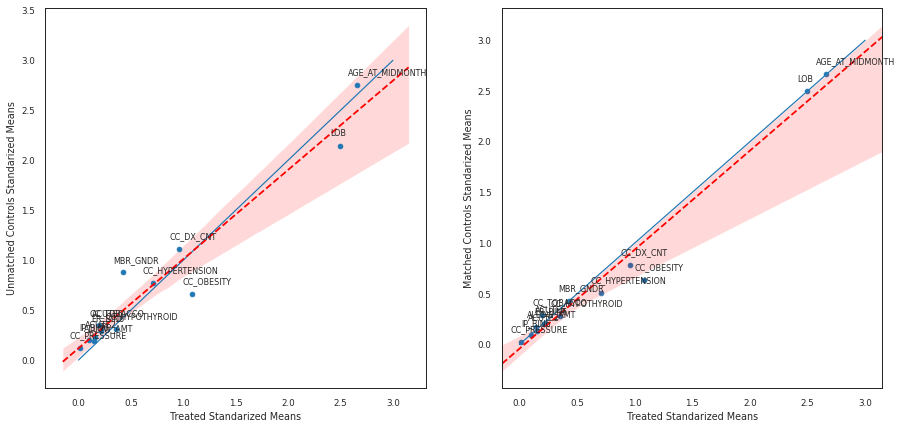

In [100]:
fig, ax = plt.subplots(1,2, figsize = (15,7))
ax[0].plot([0,3], [0, 3])
ax[1].plot([0,3], [0, 3])
ax[0].set_xlabel('Treated Standarized Means')
ax[0].set_ylabel('Unmatched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['Controls'].values,scatter = False, ax = ax[0],line_kws={"color": "red","linestyle" : '--'
})

ax[0].scatter(stdMeans['Treated'], stdMeans['Controls'])
ax[1].scatter(stdMeans['Treated'], stdMeans['MControls'])
ax[1].set_xlabel('Treated Standarized Means')
ax[1].set_ylabel('Matched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['MControls'].values, scatter = False,ax = ax[1], line_kws={"color": "red","linestyle" : '--'
})
for i, name in enumerate(list(stdMeans.index)):
    ax[0].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['Controls'].iloc[i]), fontsize = 'small',
                   textcoords = 'offset points',xytext = (-10,10))
    ax[1].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['MControls'].iloc[i]),fontsize = 'small',
                   textcoords = 'offset points', xytext = (-10,10))

fig.savefig(result_base+"figures/std_means_graph.png")
fig.show()

# Ratio Stats

In [101]:
disease_cols = [cols for cols in treated.columns if "CC" in cols and cols!='CC_DX_CNT']
other_binary_cols = ['MBR_GNDR', 'LOB', 'PREGNANCY', 'IP_BIN', 'ER_BIN', 'ACUTE']
binary_cols = other_binary_cols + disease_cols 
restricted_cols = ['PERS_ID', 'MYR', 'MEDICAID_LOB']
continuous_cols = [cols for cols in treated.columns if cols not in binary_cols + restricted_cols]

In [102]:
def calculate_continuous_d(t, c):
    Xt = np.mean(t)
    Xc = np.mean(c)
    St = np.std(t)
    Sc = np.std(c)
    d = np.abs((Xt-Xc)/(np.sqrt((St**2 + Sc**2)/2)))
    return d

In [103]:
def calculate_binary_d(t, c):
    Pt = np.mean(t)
    Pc = np.mean(c)
    d = np.abs((Pt-Pc)/(np.sqrt((Pt*(1-Pt)+Pc*(1-Pc))/2)))
    return d

In [104]:
d_metric_before = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated_original[[col]].values, controls_original[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated_original[[col]].values, controls_original[[col]].values)
        d_metric_before.loc[0,col] = d

In [105]:
d_metric_before

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.530358         0.092488   0.019968  0.006935  0.022286  0.035068      0.125096           0.208282  0.052591   0.061091              0.11784      0.005917   0.077033       0.154677   0.094578     0.02979  0.152311          0.070428     0.071426           0.014078           0.295809              0.048167  0.141256            0.028147       0.070037                 0.061804           0.055776     0.440549         0.133245   0.116179               0.013681     0.054492         0.004089     0.071661           0.074579          0.141264        0.014046              0.001303                0.019057               0.02396                0.064657                    0.044344        0.005492        0.004042          0.067846         0.061257            0.13576         0.090343        0.028193      0.068473      0.19364        0.055275      0.012445  0.028532        0.048134     0.177036            0.061717               0.065727               0.030017    0.478547         0.087685   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN    ER_BIN     ACUTE    IP_C    ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2    ACUTE2  HasPast  
0       0.203177        0.004622     0.133538            0.100294  0.044208          0.087072                0.120822        0.049509         0.006304   0.061793    0.155144            0.008416          0.047475  0.435424    0.03231  0.069515  0.064048  0.086992  0.0769  0.0074  0.017141  0.137075  0.112263  0.154748  0.092436  0.081752  0.111771  0.23801

In [106]:
d_metric_before.T.to_csv(result_base+"stats_matching/d_metric_before.csv", header=True, index=True)

In [107]:
d_metric_before.T[d_metric_before.T[0]<0.1].size

62

In [108]:
d1 = d_metric_before.loc[:,:'LOB']

In [109]:
d1

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.530358         0.092488   0.019968  0.006935  0.022286  0.035068      0.125096           0.208282  0.052591   0.061091              0.11784      0.005917   0.077033       0.154677   0.094578     0.02979  0.152311          0.070428     0.071426           0.014078           0.295809              0.048167  0.141256            0.028147       0.070037                 0.061804           0.055776     0.440549         0.133245   0.116179               0.013681     0.054492         0.004089     0.071661           0.074579          0.141264        0.014046              0.001303                0.019057               0.02396                0.064657                    0.044344        0.005492        0.004042          0.067846         0.061257            0.13576         0.090343        0.028193      0.068473      0.19364        0.055275      0.012445  0.028532        0.048134     0.177036            0.061717               0.065727               0.030017    0.478547         0.087685   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  
0       0.203177        0.004622     0.133538            0.100294  0.044208          0.087072                0.120822        0.049509         0.006304   0.061793    0.155144            0.008416          0.047475  0.435424

In [110]:
d1.T[d1.T[0]<0.1].size

53

In [111]:
d_metric_after = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated_original[[col]].values, matched_controls_original[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated_original[[col]].values, matched_controls_original[[col]].values)
        d_metric_after.loc[0,col] = d

In [112]:
d_metric_after.T.to_csv(result_base+"stats_matching/d_metric_after.csv", header=True, index=True)

In [113]:
d_metric_after.T[d_metric_after.T[0]<0.1].size

79

In [114]:
d2 = d_metric_after.loc[:,:'LOB']

In [115]:
d2.T[d2.T[0]<0.1].size

66

In [116]:
ratio = d_metric_after/d_metric_before
ratio

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0   0.01269         0.365278   0.241012  1.155822  0.108586  1.779291      0.294538           0.437399  0.196342   0.342178             0.245189       4.84941   0.816661       0.052064   0.309551    0.092431  0.110918          0.733566     0.236599           0.958801           0.145262              0.755706  0.023078            1.496837        0.72785                 0.225545           0.729891     0.384405         0.147446   1.615348                0.21471     0.623075         1.389996     0.127294           0.210873          0.263789             NaN              7.670408                0.096511                   NaN                0.060598                     0.62638             NaN             NaN          0.028688         0.545817           0.658563         1.821516        1.339645      0.731939     0.065752        0.738274      0.512906   0.39207        0.535078     0.484545            0.177216               0.478573               0.210445    0.845307         0.523518   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN   ER_BIN     ACUTE      IP_C      ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2    ACUTE2   HasPast  
0        0.02676        2.514319     0.182544            0.104334  0.830684           0.56987                0.576532        0.215207         5.728806   0.028964    0.710084            1.367808          0.322113  0.017407   0.578395  0.215036  0.04675  0.103233  0.192061  3.794445  1.721857  0.195181  0.045009  0.043279  0.222366  0.011539  0.085423  0.790074

In [117]:
ratio.T[ratio.T[0]>=1.0].size

14

In [118]:
ratio.T.to_csv(result_base+"stats_matching/ratio.csv", header=True, index=True)

In [119]:
!aws s3 cp ./Final/Data/AE_g s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_g --recursive --acl bucket-owner-full-control

upload: Final/Data/AE_g/matched0.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_g/matched0.p
upload: Final/Data/AE_g/matched_controls_latent_from_algo.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_g/matched_controls_latent_from_algo.p
upload: Final/Data/AE_g/matched_controls_aggregate.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_g/matched_controls_aggregate.p
upload: Final/Data/AE_g/matched_controls_original.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_g/matched_controls_original.p
upload: Final/Data/AE_g/matched_controls_latent_after_process.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_g/matched_controls_latent_after_process.p
upload: Final/Data/AE_g/controls_all.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_g/controls_all.p
